# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


in bash shell in the current working directory type 

```bash
unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001
```

In [1]:
#
# Add your code here
#
# from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# drive.mount('/content/drive')
# paths=['/content/drive/MyDrive/train_val']


# set this to the path where you unzip the Google Driver zip download
# in bash shell in the current working directory type `unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001`
path='./train_val'

images = []
ages = []
genders = [] 

files = os.listdir(path)
i=0
for file in files:
  i=i+1
  age = file.split("_")[0]
  gender = file.split("_")[1]
  if i % 500 == 0:
    print("File: %s, Age: %s, Gender: %s" %(file, age, gender))
  # if gender != '0' and gender != '1':
  #   print(img)
  img = cv2.imread(path+"/"+file)
  img = cv2.resize(img,(128,128))
  images.append(np.array(img))
  genders.append(np.array(gender))
  ages.append(np.array(age))
    # if i == 100:
    #   break
images = np.array(images,np.float32)
genders = np.array(genders,np.int64)
ages = np.array(ages,np.int64)
images.shape

File: 35_1_1_20170117190321049.jpg.chip.jpg, Age: 35, Gender: 1
File: 24_0_0_20170116220755400.jpg.chip.jpg, Age: 24, Gender: 0
File: 1_0_2_20170116194202388.jpg.chip.jpg, Age: 1, Gender: 0
File: 50_0_3_20170119195746908.jpg.chip.jpg, Age: 50, Gender: 0
File: 26_1_1_20170116160918398.jpg.chip.jpg, Age: 26, Gender: 1
File: 86_1_0_20170110180108013.jpg.chip.jpg, Age: 86, Gender: 1
File: 16_1_0_20170117193255060.jpg.chip.jpg, Age: 16, Gender: 1
File: 35_0_0_20170116233057278.jpg.chip.jpg, Age: 35, Gender: 0
File: 43_0_1_20170104185752431.jpg.chip.jpg, Age: 43, Gender: 0
File: 34_1_3_20170105001226421.jpg.chip.jpg, Age: 34, Gender: 1


(5000, 128, 128, 3)

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

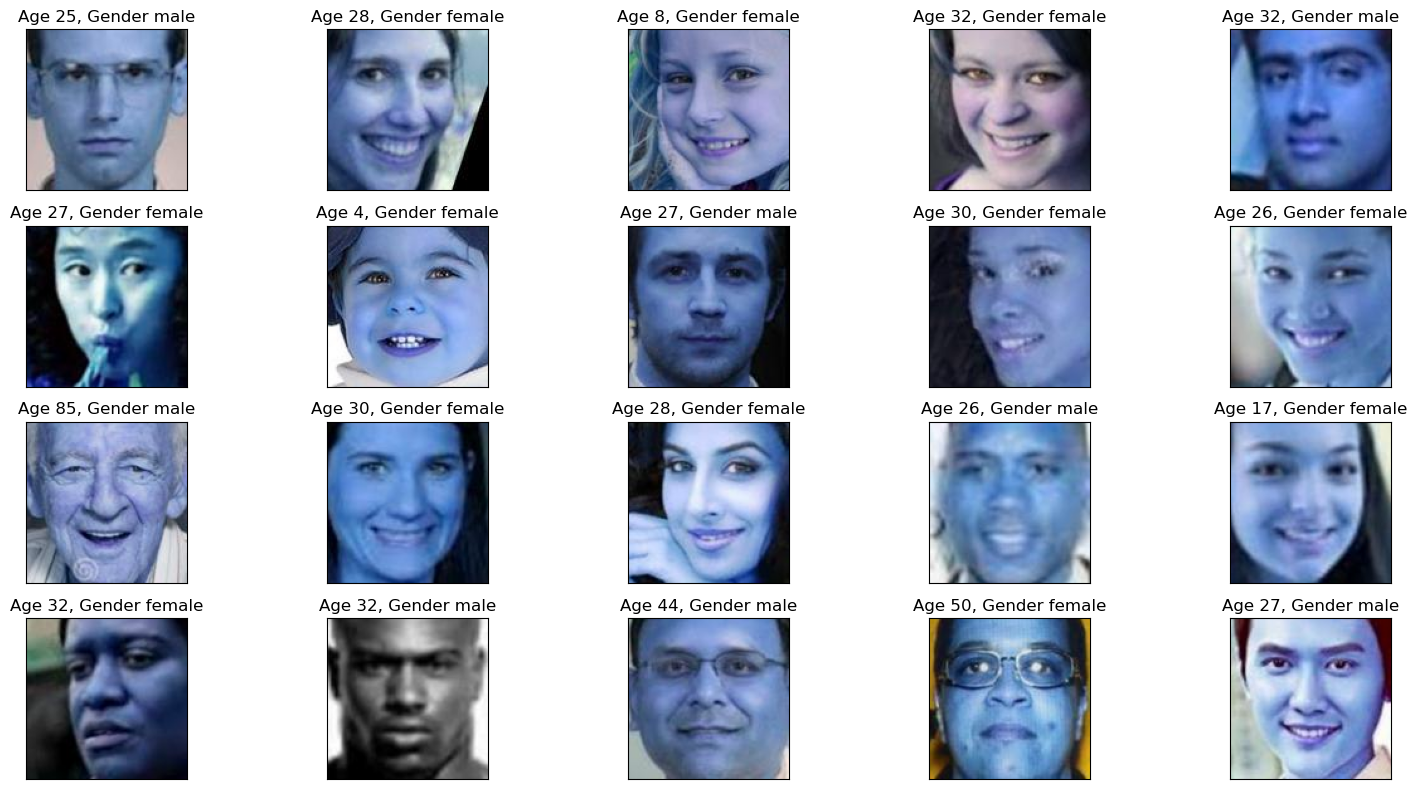

In [53]:
#
# Add your code here
# why would you ever do the plotting/display before ## STEP1: Data pre-processing
# imshow only works on data scaled between 0 and 1 so do pre-processing first
pixels2 = images/255

my_arr = np.array(range(0,20)).reshape((4,5))
gender_dict = {0:'male', 1:'female'}
fig, ax = plt.subplots(4, 5, figsize=(16,8))

for i in range(0,4):
  for j in range(0,5):
    # print(my_arr[i][j])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].grid(False)
    ax[i][j].imshow(pixels2[my_arr[i][j]])
    ax[i][j].set_title("Age %d, Gender %s" % (ages[my_arr[i][j]], gender_dict[genders[my_arr[i][j]]]))
fig.tight_layout()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [2]:
#
# Add your code here
#
from sklearn.model_selection import train_test_split

(x_train, x_test,
 y_train_gender, y_test_gender,
 y_train_age, y_test_age) = train_test_split(*[images,genders,ages],random_state=100,train_size=0.8)

# x_train=x_train/255
# x_test=x_test/255
print(x_train.shape, x_test.shape, np.unique(y_train_gender, return_counts=True))


(4000, 128, 128, 3) (1000, 128, 128, 3) (array([0, 1]), array([2090, 1910]))


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

[data_augmenter](https://github.com/berkayalan/neural-networks-and-deep-learning/blob/master/Transfer_learning_with_MobileNet_v1.ipynb)

In [8]:
from tensorflow.keras import layers 

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


# x_train=x_train/255
# x_test=x_test/255

# x_train2 = [img_augmentation(i) for i in x_train]
# np.save('x_train2.npy',x_train2)

## augment every 25th image
x_train3 = []
for i, image in enumerate(x_train):
    if i % 10 == 0:
        print(i)
        x_train3.append(img_augmentation(image))
    else:
        x_train3.append(image)
np.save('x_train3.npy', x_train3)
x_train3=np.load('x_train3.npy')

# x_test2 = [img_augmentation(i) for i in x_test]
# np.save('x_test2.npy', x_test2)
# x_train2=np.load('x_train2.npy')
# x_train2.shape
# we can test augmenting later but not sure we want/need to

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [3]:
# x_test2 = np.load('x_test2.npy')
# x_train2=np.load('x_train2.npy')
# print(x_test2.shape, x_train2.shape)

(1000, 128, 128, 3) (4000, 128, 128, 3)


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [4]:
# input_shape = (128, 128, 3)
# inputs = Input(shape=input_shape)
# hex(id(inputs))

Model: "faces"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 activation_54 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_54 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_73 (Dropout)        (None, 64, 64, 16)        0     

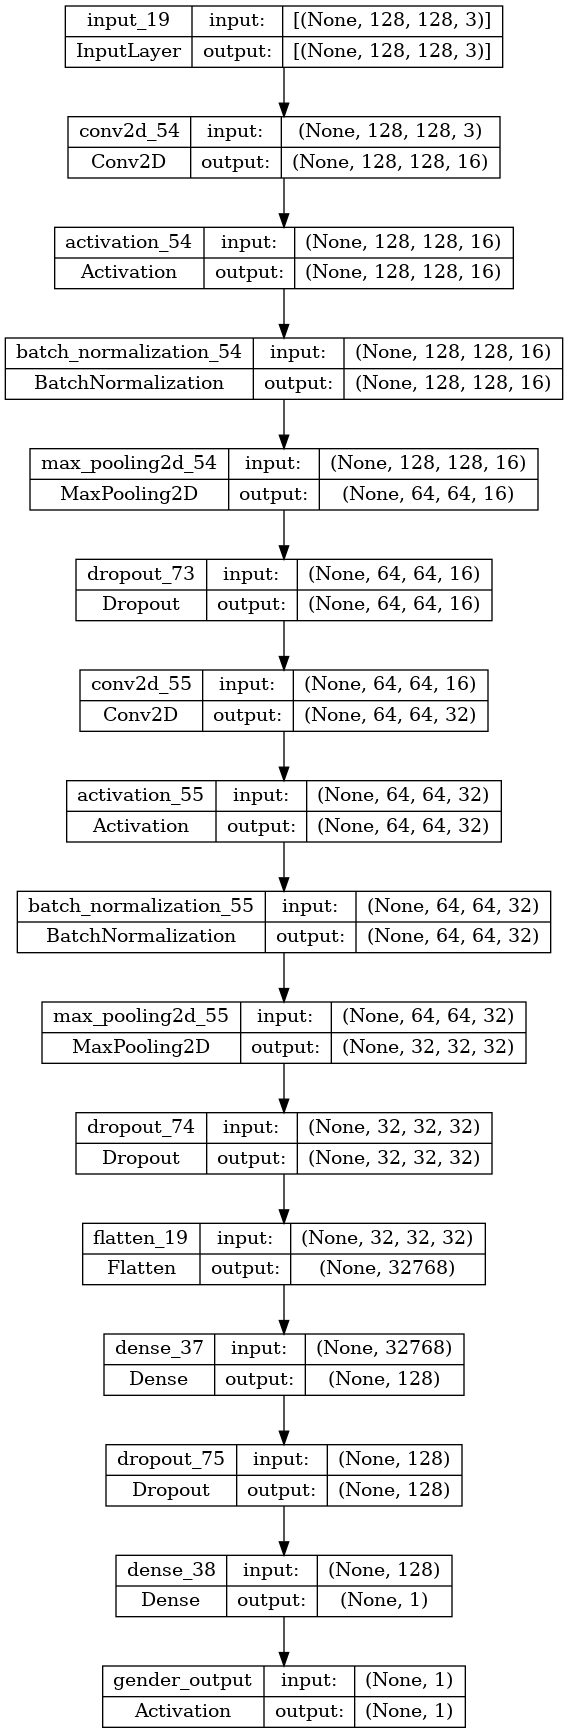

In [68]:
# import tensorflow as tf
# # from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt
# from keras.models import Sequential,load_model,Model
# from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Input,Activation
# from tensorflow.keras import layers 
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint

# # no_of_conv_layers=(16,32) # 2 Conv2D layers
# input_shape = (128, 128, 3)
# inputs=Input(shape=input_shape)
# x=inputs # input layer

# # for filters in no_of_conv_layers:
# #     print("Number filters per Conv2d layer:%s" % filters)
# x=Conv2D(filters=16, kernel_size=(3,3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(x) # call Conv2D layer on (x)
# x=Activation('relu')(x) # call Activation layer on (x)
# x=BatchNormalization(axis=-1)(x) # call BatchNormalization layer on (x)
# x=MaxPooling2D(pool_size = (2,2))(x) # call BatchNormalization layer on (x)
# x=Dropout(0.1)(x) # call BatchNormalization layer on (x)

# x=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(x) # call Conv2D layer on (x)
# x=Activation('relu')(x) # call Activation layer on (x)
# x=BatchNormalization(axis=-1)(x) # call BatchNormalization layer on (x)
# x=MaxPooling2D(pool_size = (2,2))(x) # call BatchNormalization layer on (x)
# x=Dropout(0.1)(x) # call BatchNormalization layer on (x)
    
# # x=make_upstream(inputs, no_of_conv_layers)
# x=Flatten()(x)
# x=Dense(128,activation='relu')(x)
# x=Dropout(0.2)(x)
# x=Dense(1)(x)
# x=Activation("sigmoid", name="gender_output")(x)

# modelA = Model(inputs=inputs,
#                outputs=x,
#                name="faces")

# modelA.summary()

# from tensorflow.keras.utils import plot_model
# plot_model(modelA, show_shapes=True)

Number filters per Conv2d layer:16
Number filters per Conv2d layer:32
Number filters per Conv2d layer:64


2024-02-25 22:07:46.019034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 22:07:46.148006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 22:07:46.148158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Number filters per Conv2d layer:128
Number filters per Conv2d layer:16
Number filters per Conv2d layer:32
Number filters per Conv2d layer:64
Number filters per Conv2d layer:128


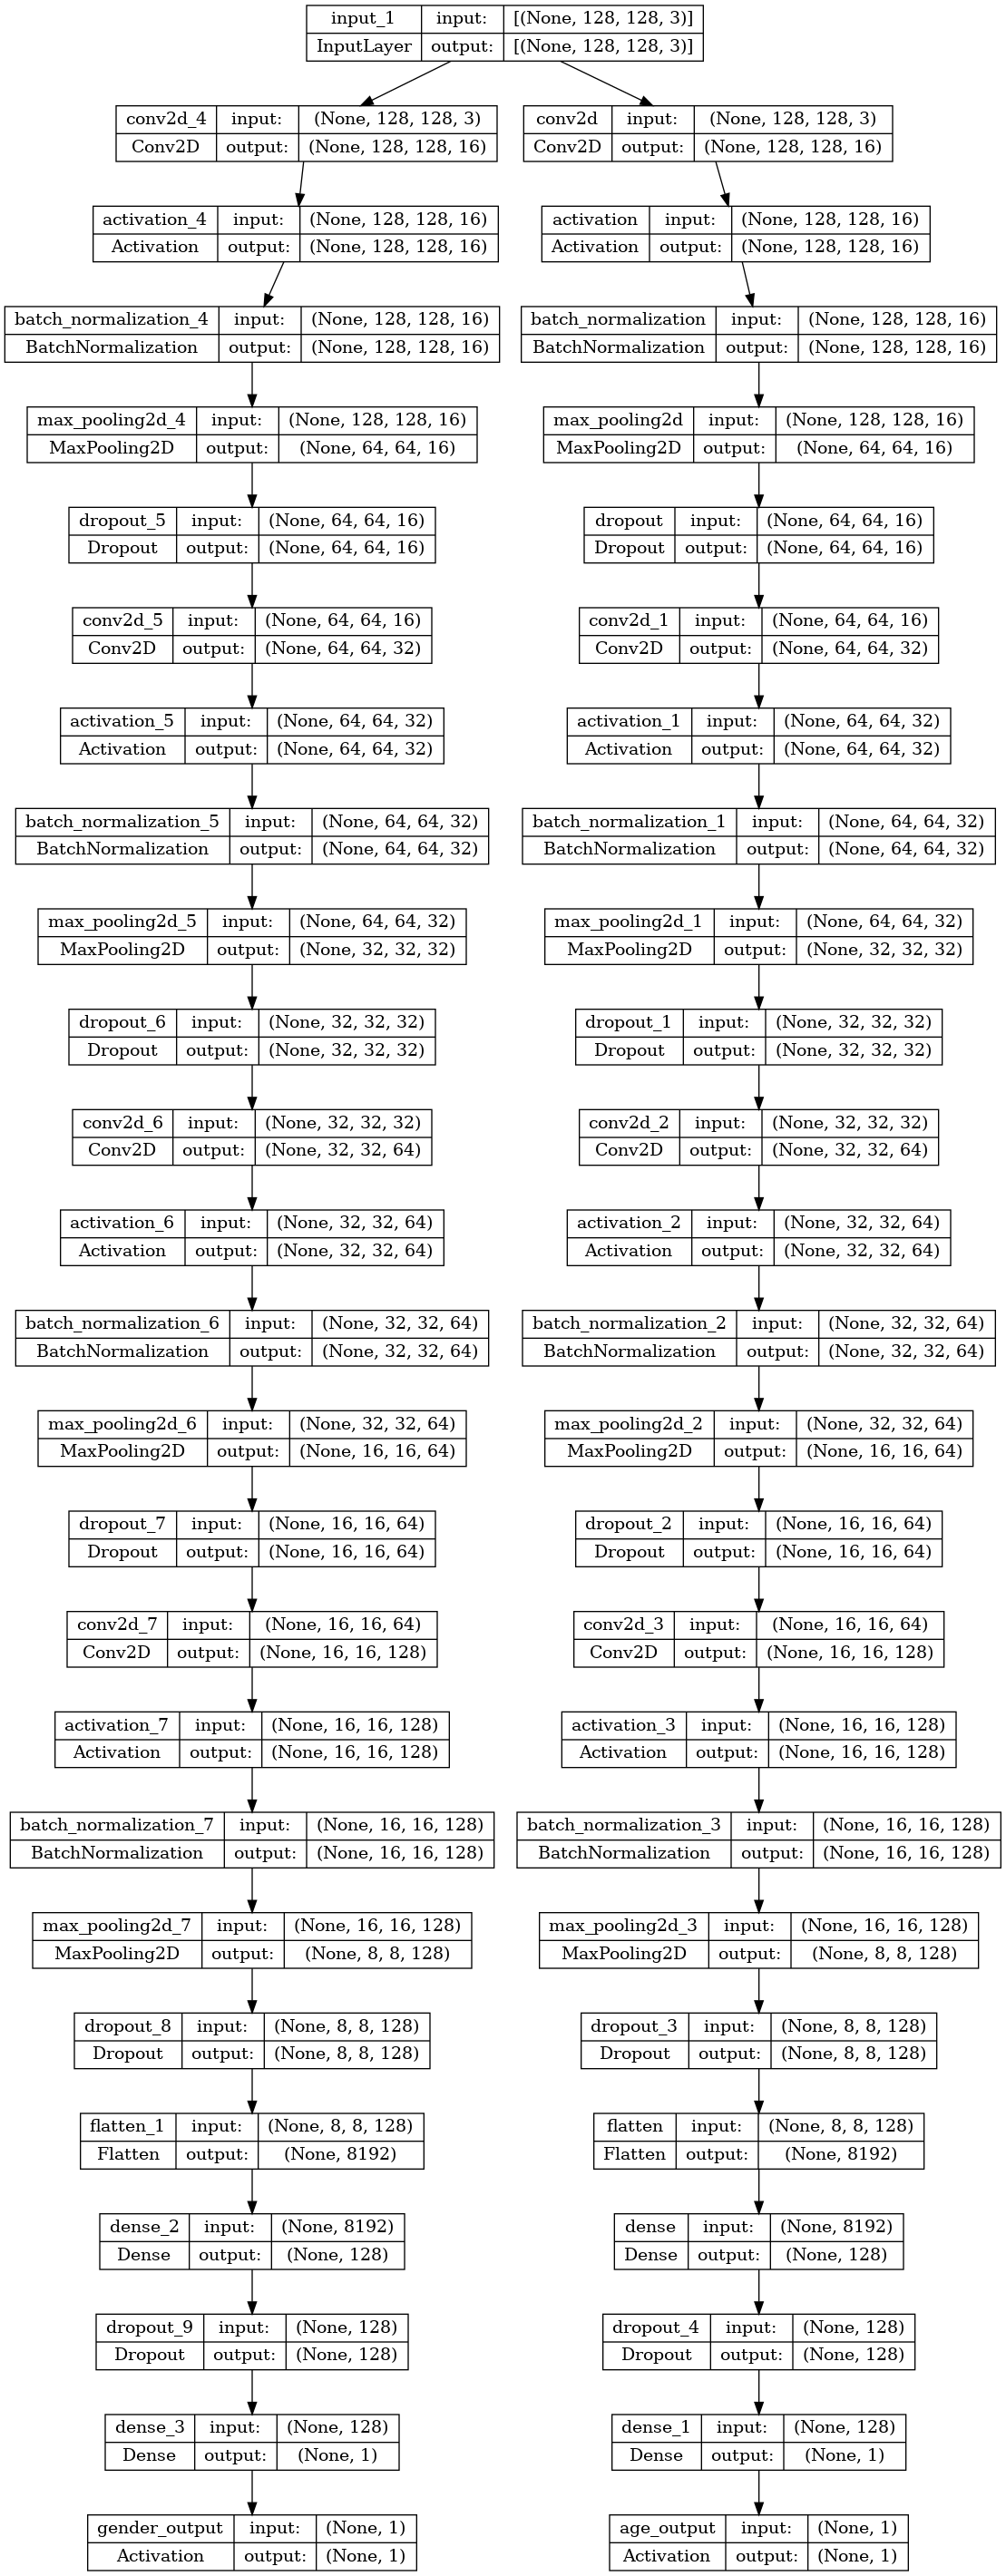

In [5]:
# Import dependencies
import tensorflow as tf
import pandas as pd
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


def make_upstream(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the header of the model
    '''
    x=inputs

    for filters in no_of_conv_layers:
        print("Number filters per Conv2d layer:%s" % filters)
        x=Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(x)
        x=Activation('relu')(x)
        x=BatchNormalization(axis=-1)(x)
        x=MaxPooling2D(pool_size = (2,2))(x)
        x=Dropout(0.2)(x) # increase from 0.1 to decrease overfitting

    return x


def build_age_branch(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the age_branch of the model
    '''
    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(1)(x)
    x=Activation("linear", name="age_output")(x)
    
    return x


def build_gender_branch(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the gender_branch of the model
    '''
    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(1)(x)
    x=Activation("sigmoid", name="gender_output")(x)

    
    return x

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)
age_branch = build_age_branch(inputs, no_of_conv_layers=(16,32,64,128))
gender_branch = build_gender_branch(inputs, no_of_conv_layers=(16,32,64,128))

modelA = Model(inputs=inputs,
               outputs = [gender_branch, age_branch],
               name="faces")
# modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)


In [6]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [9]:
#
# Add your code here
#-
# modelA = Model(inputs=inputs,
#                outputs = [gender_branch,age_branch],
#                name="faces")

num_epochs=5
model_folder='output/'
checkpointer = ModelCheckpoint(model_folder, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list=[checkpointer]

modelA.compile(optimizer=Adam(),loss={'gender_output':'binary_crossentropy',
                                      'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})
modelA.fit(x=x_train3,
           y={"gender_output": y_train_gender, "age_output": y_train_age},
           validation_data=(x_test,{"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], batch_size=8)

# modelA.save(model_folder+"age_gender_A.h5")

Epoch 1/5


2024-02-25 22:09:40.395679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infaces/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - ETA: 0s - loss: 139.8177 - gender_output_loss: 0.3477 - age_output_loss: 139.0237 - gender_output_accuracy: 0.8382 - age_output_mae: 8.9974
Epoch 1: loss improved from inf to 139.81772, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 20s 32ms/step - loss: 139.8177 - gender_output_loss: 0.3477 - age_output_loss: 139.0237 - gender_output_accuracy: 0.8382 - age_output_mae: 8.9974 - val_loss: 145.1199 - val_gender_output_loss: 0.3783 - val_age_output_loss: 144.2747 - val_gender_output_accuracy: 0.8170 - val_age_output_mae: 8.7571
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 120.9881 - gender_output_loss: 0.3454 - age_output_loss: 120.1561 - gender_output_accuracy: 0.8415 - age_output_mae: 8.2535
Epoch 2: loss improved from 139.81772 to 120.98809, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 21s 42ms/step - loss: 120.9881 - gender_output_loss: 0.3454 - age_output_loss: 120.1561 - gender_output_accuracy: 0.8415 - age_output_mae: 8.2535 - val_loss: 270.6685 - val_gender_output_loss: 0.3063 - val_age_output_loss: 269.8555 - val_gender_output_accuracy: 0.8550 - val_age_output_mae: 12.5307
Epoch 3/5
498/500 [============================>.] - ETA: 0s - loss: 113.7582 - gender_output_loss: 0.3193 - age_output_loss: 112.9146 - gender_output_accuracy: 0.8622 - age_output_mae: 8.0597
Epoch 3: loss improved from 120.98809 to 113.52641, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 16s 31ms/step - loss: 113.5264 - gender_output_loss: 0.3193 - age_output_loss: 112.6828 - gender_output_accuracy: 0.8622 - age_output_mae: 8.0514 - val_loss: 191.3270 - val_gender_output_loss: 0.3210 - val_age_output_loss: 190.4596 - val_gender_output_accuracy: 0.8680 - val_age_output_mae: 9.8994
Epoch 4/5
498/500 [============================>.] - ETA: 0s - loss: 104.6261 - gender_output_loss: 0.2930 - age_output_loss: 103.7672 - gender_output_accuracy: 0.8727 - age_output_mae: 7.6939
Epoch 4: loss improved from 113.52641 to 104.66853, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 21s 42ms/step - loss: 104.6685 - gender_output_loss: 0.2924 - age_output_loss: 103.8102 - gender_output_accuracy: 0.8733 - age_output_mae: 7.6974 - val_loss: 142.9302 - val_gender_output_loss: 0.2904 - val_age_output_loss: 142.0530 - val_gender_output_accuracy: 0.8710 - val_age_output_mae: 8.6173
Epoch 5/5
498/500 [============================>.] - ETA: 0s - loss: 96.4584 - gender_output_loss: 0.2787 - age_output_loss: 95.5722 - gender_output_accuracy: 0.8790 - age_output_mae: 7.4547
Epoch 5: loss improved from 104.66853 to 96.36247, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 15s 29ms/step - loss: 96.3625 - gender_output_loss: 0.2788 - age_output_loss: 95.4761 - gender_output_accuracy: 0.8790 - age_output_mae: 7.4536 - val_loss: 140.5925 - val_gender_output_loss: 0.3571 - val_age_output_loss: 139.6053 - val_gender_output_accuracy: 0.8490 - val_age_output_mae: 8.3159


In [11]:
model_folder='output/'
modelA.save(model_folder+"age_gender_A.h5")
# modelA = load_model(model_folder+"age_gender_A.h5")
# modelA.evaluate(x_test, {"gender_output": y_test_gender, "age_output": y_test_age})

/home/coyote/miniconda3/envs/cnn_proj/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


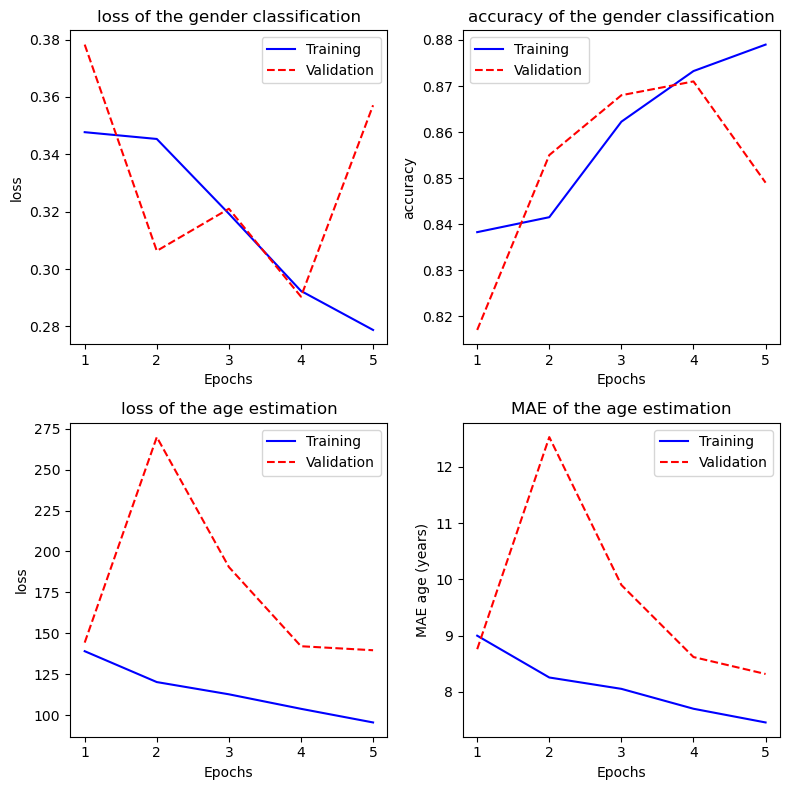

In [12]:
#
# Add your code here
#
history = modelA.history.history
plots = [
    [[history['gender_output_loss'],history['val_gender_output_loss']],
     [history['gender_output_accuracy'],history['val_gender_output_accuracy']]],
    [[history['age_output_loss'],history['val_age_output_loss']],
     [history['age_output_mae'],history['val_age_output_mae']]]
]

y_axis = [['loss', 'accuracy'],
          ['loss', 'MAE age (years)']]

titles = [['loss of the gender classification', 'accuracy of the gender classification'],
          ['loss of the age estimation', 'MAE of the age estimation']]

fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in range(0,2):
    for j in range(0,2):
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][0], label='Training', linestyle='-', color='blue')
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][1], label='Validation', linestyle='--', color='red')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel(y_axis[i][j])
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend()
fig.tight_layout()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [1]:
# import tensorflow_hub as hub
# import tensorflow as tf
# model_gcs_path = "gs://tfhub-modules/sayakpaul/convnext_tiny_1k_224/1/uncompressed"
# model = tf.keras.models.load_model(model_gcs_path)
# print(model.summary(expand_nested=True))
#
# Add your code here
#
# from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# drive.mount('/content/drive')
# paths=['/content/drive/MyDrive/train_val']


# set this to the path where you unzip the Google Driver zip download
# in bash shell in the current working directory type `unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001`
path='./train_val'

pixels = []
ages = []
genders = [] 

files = os.listdir(path)
i=0
for img in files:
  i=i+1
  gender = img.split("_")[1]
  age = img.split("_")[0]
  if gender != '0' and gender != '1':
    print(img)
  img = cv2.imread(str(path)+"/"+str(img))
  img=cv2.resize(img,(128,128))
  pixels.append(np.array(img))
  genders.append(np.array(gender))
  ages.append(np.array(age))
    # if i == 100:
    #   break
pixels = np.array(pixels,np.float32)
genders = np.array(genders,np.int64)
ages = np.array(ages,np.int64)

#
# Add your code here
#
from sklearn.model_selection import train_test_split

(x_train, x_test,
 y_train_gender, y_test_gender,
 y_train_age, y_test_age) = train_test_split(pixels,genders,ages,random_state=100,train_size=0.8)

x_train=x_train/255
x_test=x_test/255

# Import dependencies
import tensorflow as tf
import pandas as pd
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input,AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                        weights='imagenet', 
                                        input_tensor=inputs,
                                        input_shape=input_shape, 
                                        pooling=None, 
                                        classes=2,
                                        classifier_activation='softmax',
                                       )
from tensorflow.keras.applications import VGG19
model_resnet50 = VGG19(include_top=False, 
                      weights='imagenet', 
                      input_tensor=inputs,
                      input_shape=input_shape, 
                      pooling=None, 
                      classes=2,
                      classifier_activation='softmax')

# model_resnet50.trainable = False
# Freeze the layers except the last sets of convolutions
# for layer in model_resnet50.layers[:14]:
#  layer.trainable = False
# Check the trainable status of the individual layers
# for layer in model_resnet50.layers:
#  print(layer, layer.trainable)
# n=99
# for layer in model_resnet50.layers[:n]:
#     layer.trainable = False
# for layer in model_resnet50.layers[n:]:
#     layer.trainable = True

2024-02-25 23:30:39.928779: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 23:30:39.950845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 23:30:39.950872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 23:30:39.951531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 23:30:39.955693: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model_resnet50.layers[:-5]

In [3]:
model_resnet50.layers[:-5]
n=5
for layer in model_resnet50.layers[:-n]:
    layer.trainable = False
for layer in model_resnet50.layers[-n:]:
    layer.trainable = True
for layer in model_resnet50.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fd365175a10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd3544d4590> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd35438e410> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd354536310> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd3604feb50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd365c9a3d0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd354540c50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd354557e50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd3545420d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd3543a3050> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd3543cbc10> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd3543d5ad0> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [18]:
# from tensorflow.keras import layers

# img_augmentation_layers = [
#     layers.RandomRotation(factor=0.15),
#     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     layers.RandomFlip(),
#     layers.RandomContrast(factor=0.1),
# ]


# def img_augmentation(images):
#     for layer in img_augmentation_layers:
#         images = layer(images)
#     return images

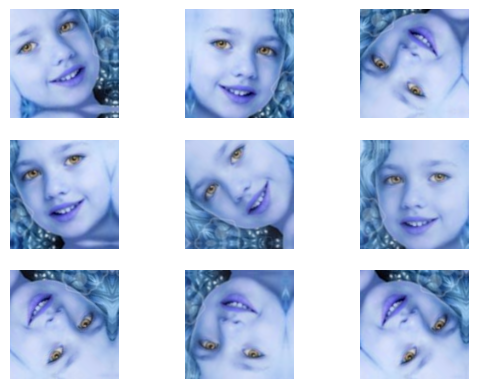

In [14]:
# image = x_train[0]
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     aug_img = img_augmentation(np.expand_dims(image, axis=0))
#     aug_img = np.array(aug_img)
#     plt.imshow(aug_img[0])
#     plt.axis("off")

In [4]:
num_epochs=25
x_train3=np.load('x_train3.npy')
model_folder='output/'
checkpointer = ModelCheckpoint(model_folder, monitor='loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list=[checkpointer]

model_resnet50.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy', metrics='accuracy')

headModel=model_resnet50.output


headModel_gender=AveragePooling2D(pool_size=(2,2))(headModel)
headModel_gender=Flatten()(headModel_gender)
headModel_gender=Dense(128,activation='relu')(headModel_gender)
headModel_gender=Dropout(0.4)(headModel_gender)
headModel_gender=Dense(1)(headModel_gender)
headModel_gender=Activation("sigmoid", name="gender_output")(headModel_gender)

headModel_age=AveragePooling2D(pool_size=(2,2))(headModel)
headModel_age=Flatten()(headModel_age)
headModel_age=Dense(128,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(1)(headModel_age)
headModel_age=Activation("linear", name="age_output")(headModel_age)

modelB = Model(inputs=model_resnet50.input, outputs=[headModel_gender, headModel_age])
modelB.compile(optimizer=Adam(learning_rate=1e-3),loss={'gender_output':'binary_crossentropy',
                                      'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})
modelB.fit(x=x_train3,
           y={"gender_output": y_train_gender, "age_output": y_train_age},
           validation_data=(x_test,{"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], batch_size=8)


# model.compile(optimizer=Adam(),loss='binary_crossentropy', metrics='accuracy')
# # model.summary()

# model.fit(x=x_train,
#            y=y_train_gender,
#            validation_data=(x_test, y_test_gender),
#            epochs=num_epochs, callbacks=[callback_list], batch_size=8)

Epoch 1/25


2024-02-25 23:31:05.629075: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-25 23:31:06.445670: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-25 23:31:06.445728: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-25 23:31:06.554500: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

500/500 [==============================] - ETA: 0s - loss: 741.2068 - gender_output_loss: 0.9348 - age_output_loss: 740.2729 - gender_output_accuracy: 0.5178 - age_output_mae: 13.5665
Epoch 1: loss improved from inf to 741.20685, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 45s 79ms/step - loss: 741.2068 - gender_output_loss: 0.9348 - age_output_loss: 740.2729 - gender_output_accuracy: 0.5178 - age_output_mae: 13.5665 - val_loss: 149.3774 - val_gender_output_loss: 0.7052 - val_age_output_loss: 148.6722 - val_gender_output_accuracy: 0.4940 - val_age_output_mae: 9.2520
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 160.4363 - gender_output_loss: 0.7113 - age_output_loss: 159.7249 - gender_output_accuracy: 0.5472 - age_output_mae: 9.2977
Epoch 2: loss improved from 741.20685 to 160.43629, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 38s 76ms/step - loss: 160.4363 - gender_output_loss: 0.7113 - age_output_loss: 159.7249 - gender_output_accuracy: 0.5472 - age_output_mae: 9.2977 - val_loss: 127.4957 - val_gender_output_loss: 0.6743 - val_age_output_loss: 126.8214 - val_gender_output_accuracy: 0.5310 - val_age_output_mae: 8.3532
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 142.2465 - gender_output_loss: 0.6907 - age_output_loss: 141.5557 - gender_output_accuracy: 0.5587 - age_output_mae: 8.7832
Epoch 3: loss improved from 160.43629 to 142.24652, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 36s 73ms/step - loss: 142.2465 - gender_output_loss: 0.6907 - age_output_loss: 141.5557 - gender_output_accuracy: 0.5587 - age_output_mae: 8.7832 - val_loss: 125.9940 - val_gender_output_loss: 0.6760 - val_age_output_loss: 125.3179 - val_gender_output_accuracy: 0.6130 - val_age_output_mae: 7.9171
Epoch 4/25
500/500 [==============================] - ETA: 0s - loss: 110.6498 - gender_output_loss: 0.6938 - age_output_loss: 109.9559 - gender_output_accuracy: 0.5742 - age_output_mae: 7.7230
Epoch 4: loss improved from 142.24652 to 110.64984, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 39s 78ms/step - loss: 110.6498 - gender_output_loss: 0.6938 - age_output_loss: 109.9559 - gender_output_accuracy: 0.5742 - age_output_mae: 7.7230 - val_loss: 137.2301 - val_gender_output_loss: 0.6687 - val_age_output_loss: 136.5614 - val_gender_output_accuracy: 0.5920 - val_age_output_mae: 8.2354
Epoch 5/25
499/500 [============================>.] - ETA: 0s - loss: 106.2059 - gender_output_loss: 0.6752 - age_output_loss: 105.5309 - gender_output_accuracy: 0.5819 - age_output_mae: 7.4802
Epoch 5: loss improved from 110.64984 to 106.23600, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 40s 80ms/step - loss: 106.2360 - gender_output_loss: 0.6750 - age_output_loss: 105.5611 - gender_output_accuracy: 0.5820 - age_output_mae: 7.4818 - val_loss: 128.6755 - val_gender_output_loss: 0.7013 - val_age_output_loss: 127.9742 - val_gender_output_accuracy: 0.6070 - val_age_output_mae: 7.8058
Epoch 6/25
499/500 [============================>.] - ETA: 0s - loss: 81.7805 - gender_output_loss: 0.6738 - age_output_loss: 81.1067 - gender_output_accuracy: 0.5817 - age_output_mae: 6.6631
Epoch 6: loss improved from 106.23600 to 81.79697, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 39s 79ms/step - loss: 81.7970 - gender_output_loss: 0.6740 - age_output_loss: 81.1230 - gender_output_accuracy: 0.5822 - age_output_mae: 6.6635 - val_loss: 125.9387 - val_gender_output_loss: 0.6747 - val_age_output_loss: 125.2639 - val_gender_output_accuracy: 0.5730 - val_age_output_mae: 8.0529
Epoch 7/25
500/500 [==============================] - ETA: 0s - loss: 76.7873 - gender_output_loss: 0.6690 - age_output_loss: 76.1183 - gender_output_accuracy: 0.5853 - age_output_mae: 6.4843
Epoch 7: loss improved from 81.79697 to 76.78726, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 39s 79ms/step - loss: 76.7873 - gender_output_loss: 0.6690 - age_output_loss: 76.1183 - gender_output_accuracy: 0.5853 - age_output_mae: 6.4843 - val_loss: 114.0768 - val_gender_output_loss: 0.6642 - val_age_output_loss: 113.4127 - val_gender_output_accuracy: 0.6050 - val_age_output_mae: 7.4995
Epoch 8/25
499/500 [============================>.] - ETA: 0s - loss: 65.0008 - gender_output_loss: 0.6675 - age_output_loss: 64.3333 - gender_output_accuracy: 0.5749 - age_output_mae: 5.9396
Epoch 8: loss improved from 76.78726 to 65.40417, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 38s 77ms/step - loss: 65.4042 - gender_output_loss: 0.6673 - age_output_loss: 64.7369 - gender_output_accuracy: 0.5753 - age_output_mae: 5.9522 - val_loss: 137.4812 - val_gender_output_loss: 0.6587 - val_age_output_loss: 136.8224 - val_gender_output_accuracy: 0.6080 - val_age_output_mae: 7.8885
Epoch 9/25
500/500 [==============================] - ETA: 0s - loss: 64.1041 - gender_output_loss: 0.6591 - age_output_loss: 63.4451 - gender_output_accuracy: 0.5995 - age_output_mae: 5.8844
Epoch 9: loss improved from 65.40417 to 64.10413, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 39s 79ms/step - loss: 64.1041 - gender_output_loss: 0.6591 - age_output_loss: 63.4451 - gender_output_accuracy: 0.5995 - age_output_mae: 5.8844 - val_loss: 108.7111 - val_gender_output_loss: 0.6639 - val_age_output_loss: 108.0471 - val_gender_output_accuracy: 0.6020 - val_age_output_mae: 7.3528
Epoch 10/25
500/500 [==============================] - ETA: 0s - loss: 55.0424 - gender_output_loss: 0.6602 - age_output_loss: 54.3821 - gender_output_accuracy: 0.5995 - age_output_mae: 5.4453
Epoch 10: loss improved from 64.10413 to 55.04237, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 55.0424 - gender_output_loss: 0.6602 - age_output_loss: 54.3821 - gender_output_accuracy: 0.5995 - age_output_mae: 5.4453 - val_loss: 127.7926 - val_gender_output_loss: 0.6685 - val_age_output_loss: 127.1241 - val_gender_output_accuracy: 0.5750 - val_age_output_mae: 8.1890
Epoch 11/25
500/500 [==============================] - ETA: 0s - loss: 44.1391 - gender_output_loss: 0.6685 - age_output_loss: 43.4706 - gender_output_accuracy: 0.5882 - age_output_mae: 4.9356
Epoch 11: loss improved from 55.04237 to 44.13910, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 44.1391 - gender_output_loss: 0.6685 - age_output_loss: 43.4706 - gender_output_accuracy: 0.5882 - age_output_mae: 4.9356 - val_loss: 103.5199 - val_gender_output_loss: 0.6673 - val_age_output_loss: 102.8526 - val_gender_output_accuracy: 0.5970 - val_age_output_mae: 7.1187
Epoch 12/25
500/500 [==============================] - ETA: 0s - loss: 47.6516 - gender_output_loss: 0.6603 - age_output_loss: 46.9913 - gender_output_accuracy: 0.6040 - age_output_mae: 5.0904
Epoch 12: loss did not improve from 44.13910
500/500 [==============================] - 31s 61ms/step - loss: 47.6516 - gender_output_loss: 0.6603 - age_output_loss: 46.9913 - gender_output_accuracy: 0.6040 - age_output_mae: 5.0904 - val_loss: 135.4884 - val_gender_output_loss: 0.6622 - val_age_output_loss: 134.8262 - val_gender_output_accuracy: 0.6000 - val_age_output_mae: 7.9235
Epoch 13/25
500/500 [==============================] - ETA: 0s - loss: 42.3832 - gen

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 42.3832 - gender_output_loss: 0.6634 - age_output_loss: 41.7197 - gender_output_accuracy: 0.5940 - age_output_mae: 4.8204 - val_loss: 158.7879 - val_gender_output_loss: 0.6804 - val_age_output_loss: 158.1075 - val_gender_output_accuracy: 0.5770 - val_age_output_mae: 8.4512
Epoch 14/25
500/500 [==============================] - ETA: 0s - loss: 42.4984 - gender_output_loss: 0.6673 - age_output_loss: 41.8311 - gender_output_accuracy: 0.5928 - age_output_mae: 4.7983
Epoch 14: loss did not improve from 42.38320
500/500 [==============================] - 31s 61ms/step - loss: 42.4984 - gender_output_loss: 0.6673 - age_output_loss: 41.8311 - gender_output_accuracy: 0.5928 - age_output_mae: 4.7983 - val_loss: 119.6605 - val_gender_output_loss: 0.6542 - val_age_output_loss: 119.0063 - val_gender_output_accuracy: 0.6300 - val_age_output_mae: 7.8315
Epoch 15/25
500/500 [==============================] - ETA: 0s - loss: 40.4408 - gen

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 40.4408 - gender_output_loss: 0.6635 - age_output_loss: 39.7774 - gender_output_accuracy: 0.5938 - age_output_mae: 4.6615 - val_loss: 114.2867 - val_gender_output_loss: 0.6560 - val_age_output_loss: 113.6307 - val_gender_output_accuracy: 0.6170 - val_age_output_mae: 7.4350
Epoch 16/25
500/500 [==============================] - ETA: 0s - loss: 33.9535 - gender_output_loss: 0.6633 - age_output_loss: 33.2901 - gender_output_accuracy: 0.5900 - age_output_mae: 4.2928
Epoch 16: loss improved from 40.44085 to 33.95348, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 33.9535 - gender_output_loss: 0.6633 - age_output_loss: 33.2901 - gender_output_accuracy: 0.5900 - age_output_mae: 4.2928 - val_loss: 104.9266 - val_gender_output_loss: 0.6621 - val_age_output_loss: 104.2644 - val_gender_output_accuracy: 0.6090 - val_age_output_mae: 7.3447
Epoch 17/25
500/500 [==============================] - ETA: 0s - loss: 34.4024 - gender_output_loss: 0.6698 - age_output_loss: 33.7326 - gender_output_accuracy: 0.5870 - age_output_mae: 4.3166
Epoch 17: loss did not improve from 33.95348
500/500 [==============================] - 31s 61ms/step - loss: 34.4024 - gender_output_loss: 0.6698 - age_output_loss: 33.7326 - gender_output_accuracy: 0.5870 - age_output_mae: 4.3166 - val_loss: 105.1580 - val_gender_output_loss: 0.6620 - val_age_output_loss: 104.4960 - val_gender_output_accuracy: 0.5980 - val_age_output_mae: 7.3104
Epoch 18/25
500/500 [==============================] - ETA: 0s - loss: 33.3664 - gen

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 33.3664 - gender_output_loss: 0.6647 - age_output_loss: 32.7017 - gender_output_accuracy: 0.5920 - age_output_mae: 4.2080 - val_loss: 101.2380 - val_gender_output_loss: 0.6661 - val_age_output_loss: 100.5719 - val_gender_output_accuracy: 0.5860 - val_age_output_mae: 7.0058
Epoch 19/25
500/500 [==============================] - ETA: 0s - loss: 32.4672 - gender_output_loss: 0.6635 - age_output_loss: 31.8037 - gender_output_accuracy: 0.6090 - age_output_mae: 4.1603
Epoch 19: loss improved from 33.36639 to 32.46718, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 32.4672 - gender_output_loss: 0.6635 - age_output_loss: 31.8037 - gender_output_accuracy: 0.6090 - age_output_mae: 4.1603 - val_loss: 120.0164 - val_gender_output_loss: 0.6646 - val_age_output_loss: 119.3518 - val_gender_output_accuracy: 0.5930 - val_age_output_mae: 7.4392
Epoch 20/25
500/500 [==============================] - ETA: 0s - loss: 33.2492 - gender_output_loss: 0.6599 - age_output_loss: 32.5893 - gender_output_accuracy: 0.6072 - age_output_mae: 4.2039
Epoch 20: loss did not improve from 32.46718
500/500 [==============================] - 31s 61ms/step - loss: 33.2492 - gender_output_loss: 0.6599 - age_output_loss: 32.5893 - gender_output_accuracy: 0.6072 - age_output_mae: 4.2039 - val_loss: 103.2411 - val_gender_output_loss: 0.6520 - val_age_output_loss: 102.5890 - val_gender_output_accuracy: 0.6050 - val_age_output_mae: 6.9463
Epoch 21/25
500/500 [==============================] - ETA: 0s - loss: 28.6402 - gen

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 67ms/step - loss: 28.6402 - gender_output_loss: 0.6575 - age_output_loss: 27.9827 - gender_output_accuracy: 0.6093 - age_output_mae: 3.8867 - val_loss: 104.9531 - val_gender_output_loss: 0.6503 - val_age_output_loss: 104.3029 - val_gender_output_accuracy: 0.6200 - val_age_output_mae: 7.2273
Epoch 22/25
500/500 [==============================] - ETA: 0s - loss: 34.8399 - gender_output_loss: 0.6630 - age_output_loss: 34.1770 - gender_output_accuracy: 0.5955 - age_output_mae: 4.1745
Epoch 22: loss did not improve from 28.64024
500/500 [==============================] - 30s 60ms/step - loss: 34.8399 - gender_output_loss: 0.6630 - age_output_loss: 34.1770 - gender_output_accuracy: 0.5955 - age_output_mae: 4.1745 - val_loss: 98.7267 - val_gender_output_loss: 0.6604 - val_age_output_loss: 98.0663 - val_gender_output_accuracy: 0.6050 - val_age_output_mae: 6.8265
Epoch 23/25
500/500 [==============================] - ETA: 0s - loss: 26.4160 - gende

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 26.4160 - gender_output_loss: 0.6627 - age_output_loss: 25.7533 - gender_output_accuracy: 0.5928 - age_output_mae: 3.7275 - val_loss: 100.4922 - val_gender_output_loss: 0.6554 - val_age_output_loss: 99.8368 - val_gender_output_accuracy: 0.6160 - val_age_output_mae: 6.8320
Epoch 24/25
500/500 [==============================] - ETA: 0s - loss: 27.3857 - gender_output_loss: 0.6584 - age_output_loss: 26.7272 - gender_output_accuracy: 0.6005 - age_output_mae: 3.7824
Epoch 24: loss did not improve from 26.41602
500/500 [==============================] - 30s 61ms/step - loss: 27.3857 - gender_output_loss: 0.6584 - age_output_loss: 26.7272 - gender_output_accuracy: 0.6005 - age_output_mae: 3.7824 - val_loss: 98.7836 - val_gender_output_loss: 0.6508 - val_age_output_loss: 98.1328 - val_gender_output_accuracy: 0.6180 - val_age_output_mae: 6.9424
Epoch 25/25
500/500 [==============================] - ETA: 0s - loss: 28.3152 - gender

In [6]:
modelB.fit(x=x_train3,
           y={"gender_output": y_train_gender, "age_output": y_train_age},
           validation_data=(x_test,{"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=25, callbacks=[callback_list], batch_size=8)


Epoch 1/25
500/500 [==============================] - ETA: 0s - loss: 26.6758 - gender_output_loss: 0.6540 - age_output_loss: 26.0218 - gender_output_accuracy: 0.6133 - age_output_mae: 3.7575
Epoch 1: loss did not improve from 26.41602
500/500 [==============================] - 31s 61ms/step - loss: 26.6758 - gender_output_loss: 0.6540 - age_output_loss: 26.0218 - gender_output_accuracy: 0.6133 - age_output_mae: 3.7575 - val_loss: 100.0073 - val_gender_output_loss: 0.6592 - val_age_output_loss: 99.3481 - val_gender_output_accuracy: 0.6190 - val_age_output_mae: 6.9995
Epoch 2/25
500/500 [==============================] - ETA: 0s - loss: 26.0466 - gender_output_loss: 0.6555 - age_output_loss: 25.3911 - gender_output_accuracy: 0.6152 - age_output_mae: 3.7000
Epoch 2: loss improved from 26.41602 to 26.04663, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 67ms/step - loss: 26.0466 - gender_output_loss: 0.6555 - age_output_loss: 25.3911 - gender_output_accuracy: 0.6152 - age_output_mae: 3.7000 - val_loss: 100.0470 - val_gender_output_loss: 0.6500 - val_age_output_loss: 99.3970 - val_gender_output_accuracy: 0.6160 - val_age_output_mae: 6.9598
Epoch 3/25
500/500 [==============================] - ETA: 0s - loss: 24.7177 - gender_output_loss: 0.6587 - age_output_loss: 24.0590 - gender_output_accuracy: 0.6045 - age_output_mae: 3.5837
Epoch 3: loss improved from 26.04663 to 24.71774, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 24.7177 - gender_output_loss: 0.6587 - age_output_loss: 24.0590 - gender_output_accuracy: 0.6045 - age_output_mae: 3.5837 - val_loss: 99.8322 - val_gender_output_loss: 0.6552 - val_age_output_loss: 99.1770 - val_gender_output_accuracy: 0.6190 - val_age_output_mae: 6.9157
Epoch 4/25
500/500 [==============================] - ETA: 0s - loss: 26.9838 - gender_output_loss: 0.6473 - age_output_loss: 26.3365 - gender_output_accuracy: 0.6177 - age_output_mae: 3.7715
Epoch 4: loss did not improve from 24.71774
500/500 [==============================] - 30s 61ms/step - loss: 26.9838 - gender_output_loss: 0.6473 - age_output_loss: 26.3365 - gender_output_accuracy: 0.6177 - age_output_mae: 3.7715 - val_loss: 100.3057 - val_gender_output_loss: 0.6399 - val_age_output_loss: 99.6659 - val_gender_output_accuracy: 0.6150 - val_age_output_mae: 7.0642
Epoch 5/25
500/500 [==============================] - ETA: 0s - loss: 28.4990 - gender_ou

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 33s 66ms/step - loss: 22.5436 - gender_output_loss: 0.6487 - age_output_loss: 21.8949 - gender_output_accuracy: 0.6283 - age_output_mae: 3.4148 - val_loss: 100.9771 - val_gender_output_loss: 0.6647 - val_age_output_loss: 100.3125 - val_gender_output_accuracy: 0.5950 - val_age_output_mae: 6.9577
Epoch 7/25
500/500 [==============================] - ETA: 0s - loss: 22.1596 - gender_output_loss: 0.6467 - age_output_loss: 21.5129 - gender_output_accuracy: 0.6170 - age_output_mae: 3.4230
Epoch 7: loss improved from 22.54362 to 22.15957, saving model to output/
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 24s 48ms/step - loss: 22.1596 - gender_output_loss: 0.6467 - age_output_loss: 21.5129 - gender_output_accuracy: 0.6170 - age_output_mae: 3.4230 - val_loss: 99.8534 - val_gender_output_loss: 0.6517 - val_age_output_loss: 99.2018 - val_gender_output_accuracy: 0.6100 - val_age_output_mae: 6.9957
Epoch 8/25
499/500 [============================>.] - ETA: 0s - loss: 26.5575 - gender_output_loss: 0.6435 - age_output_loss: 25.9140 - gender_output_accuracy: 0.6318 - age_output_mae: 3.6758
Epoch 8: loss did not improve from 22.15957
500/500 [==============================] - 18s 37ms/step - loss: 26.6627 - gender_output_loss: 0.6436 - age_output_loss: 26.0191 - gender_output_accuracy: 0.6315 - age_output_mae: 3.6784 - val_loss: 104.9295 - val_gender_output_loss: 0.6453 - val_age_output_loss: 104.2842 - val_gender_output_accuracy: 0.6220 - val_age_output_mae: 7.0968
Epoch 9/25
499/500 [============================>.] - ETA: 0s - loss: 23.1992 - gender_o

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 21s 43ms/step - loss: 20.6041 - gender_output_loss: 0.6434 - age_output_loss: 19.9608 - gender_output_accuracy: 0.6327 - age_output_mae: 3.2592 - val_loss: 98.7300 - val_gender_output_loss: 0.6523 - val_age_output_loss: 98.0777 - val_gender_output_accuracy: 0.6130 - val_age_output_mae: 6.9352
Epoch 14/25
499/500 [============================>.] - ETA: 0s - loss: 24.6957 - gender_output_loss: 0.6479 - age_output_loss: 24.0478 - gender_output_accuracy: 0.6177 - age_output_mae: 3.5368
Epoch 14: loss did not improve from 20.60411
500/500 [==============================] - 18s 37ms/step - loss: 24.7014 - gender_output_loss: 0.6479 - age_output_loss: 24.0536 - gender_output_accuracy: 0.6173 - age_output_mae: 3.5374 - val_loss: 107.3002 - val_gender_output_loss: 0.6435 - val_age_output_loss: 106.6567 - val_gender_output_accuracy: 0.6210 - val_age_output_mae: 7.1766
Epoch 15/25
499/500 [============================>.] - ETA: 0s - loss: 23.7023 - gende

INFO:tensorflow:Assets written to: output/assets


500/500 [==============================] - 21s 42ms/step - loss: 18.1001 - gender_output_loss: 0.6492 - age_output_loss: 17.4509 - gender_output_accuracy: 0.6230 - age_output_mae: 3.0314 - val_loss: 94.0910 - val_gender_output_loss: 0.6505 - val_age_output_loss: 93.4405 - val_gender_output_accuracy: 0.6050 - val_age_output_mae: 6.8346
Epoch 18/25
499/500 [============================>.] - ETA: 0s - loss: 21.3598 - gender_output_loss: 0.6459 - age_output_loss: 20.7139 - gender_output_accuracy: 0.6172 - age_output_mae: 3.2725
Epoch 18: loss did not improve from 18.10012
500/500 [==============================] - 18s 37ms/step - loss: 21.3742 - gender_output_loss: 0.6459 - age_output_loss: 20.7283 - gender_output_accuracy: 0.6175 - age_output_mae: 3.2738 - val_loss: 100.8435 - val_gender_output_loss: 0.6431 - val_age_output_loss: 100.2004 - val_gender_output_accuracy: 0.6240 - val_age_output_mae: 6.9784
Epoch 19/25
499/500 [============================>.] - ETA: 0s - loss: 18.5454 - gende

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                              

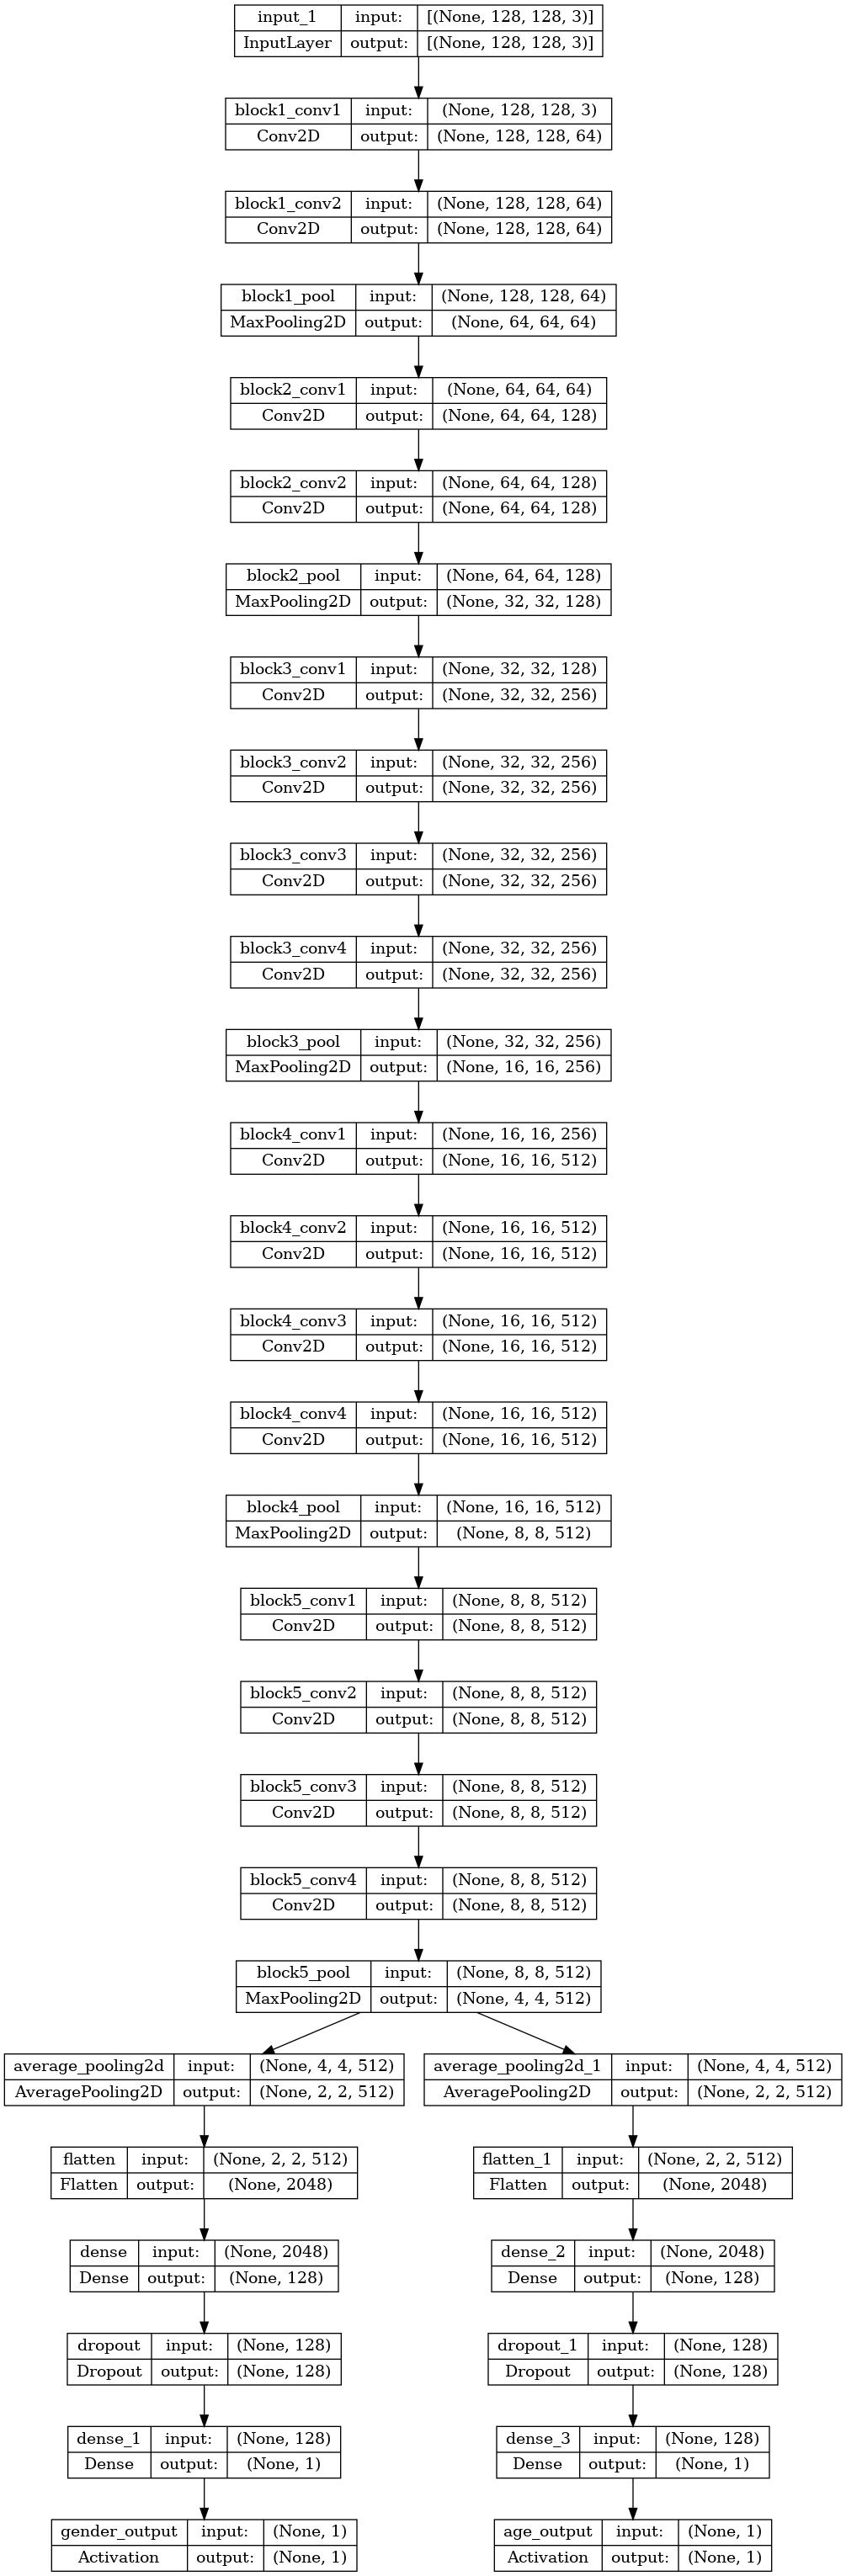

In [6]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [7]:
#
# Add your code here
#
model_folder='output/'

modelB.save(model_folder+"age_gender_B.h5")

: 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

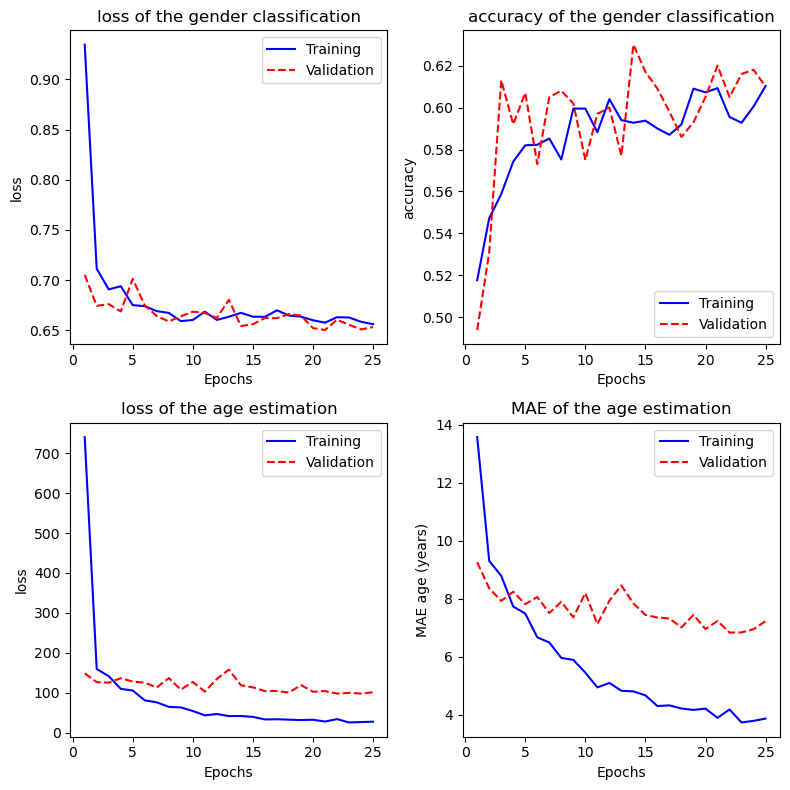

In [5]:
#
# Add your code here
#
history = modelB.history.history
plots = [
    [[history['gender_output_loss'],history['val_gender_output_loss']],
     [history['gender_output_accuracy'],history['val_gender_output_accuracy']]],
    [[history['age_output_loss'],history['val_age_output_loss']],
     [history['age_output_mae'],history['val_age_output_mae']]]
]

y_axis = [['loss', 'accuracy'],
          ['loss', 'MAE age (years)']]

titles = [['loss of the gender classification', 'accuracy of the gender classification'],
          ['loss of the age estimation', 'MAE of the age estimation']]

fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in range(0,2):
    for j in range(0,2):
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][0], label='Training', linestyle='-', color='blue')
        ax[i][j].plot(range(1,num_epochs+1),plots[i][j][1], label='Validation', linestyle='--', color='red')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel(y_axis[i][j])
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend()
fig.tight_layout()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#